In [1]:
library(dplyr)
library(tidyr)
library(purrr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



In [2]:
train = read.csv("train.csv")
train['train_or_test'] = 'train'
test = read.csv("test.csv")
test['train_or_test'] = 'test'

In [3]:
train_target <- train$SaleType
train <- train[names(train) != 'SalePrice']
al <- rbind(train, test)

In [4]:
names(al)

[1] "Id"            "MSSubClass"    "MSZoning"      "LotFrontage"  
 [5] "LotArea"       "Street"        "Alley"         "LotShape"     
 [9] "LandContour"   "Utilities"     "LotConfig"     "LandSlope"    
[13] "Neighborhood"  "Condition1"    "Condition2"    "BldgType"     
[17] "HouseStyle"    "OverallQual"   "OverallCond"   "YearBuilt"    
[21] "YearRemodAdd"  "RoofStyle"     "RoofMatl"      "Exterior1st"  
[25] "Exterior2nd"   "MasVnrType"    "MasVnrArea"    "ExterQual"    
[29] "ExterCond"     "Foundation"    "BsmtQual"      "BsmtCond"     
[33] "BsmtExposure"  "BsmtFinType1"  "BsmtFinSF1"    "BsmtFinType2" 
[37] "BsmtFinSF2"    "BsmtUnfSF"     "TotalBsmtSF"   "Heating"      
[41] "HeatingQC"     "CentralAir"    "Electrical"    "X1stFlrSF"    
[45] "X2ndFlrSF"     "LowQualFinSF"  "GrLivArea"     "BsmtFullBath" 
[49] "BsmtHalfBath"  "FullBath"      "HalfBath"      "BedroomAbvGr" 
[53] "KitchenAbvGr"  "KitchenQual"   "TotRmsAbvGrd"  "Functional"   
[57] "Fireplaces"    "FireplaceQu"   "GarageType"    "GarageYrBlt"  
[61] "GarageFinish"  "GarageCars"    "GarageArea"    "GarageQual"   
[65] "GarageCond"    "PavedDrive"    "WoodDeckSF"    "OpenPorchSF"  
[69] "EnclosedPorch" "X3SsnPorch"    "ScreenPorch"   "PoolArea"     
[73] "PoolQC"        "Fence"         "MiscFeature"   "MiscVal"      
[77] "MoSold"        "YrSold"        "SaleType"      "SaleCondition"
[81] "train_or_test"

In [14]:
desc <- function (variable){
    if (is.numeric(al[[variable]])){
            hist(al[[variable]], xlab = "", main = paste("Histogram of ", toupper(variable)))
    }
    
    else if (is.character(al[[variable]]) | is.factor(al[[variable]])){
            barplot(prop.table(table(al[[variable]])), main = paste("Barplot of ", toupper(variable)))    
        }
    }

In [6]:
# data.frame(colSums(is.na(al)))
NAs <- al %>%
    map_df(function(x) sum(is.na(x))) %>%
    gather(feature, num_nulls)  %>% 
    mutate(Na_ratio = round(num_nulls / nrow(al), 4))
NAs <- NAs[NAs$num_nulls != 0,]          
(NAs <- NAs[order(NAs$num_nulls, decreasing = T), ])

feature,num_nulls,Na_ratio
PoolQC,2909,0.9966
MiscFeature,2814,0.9640
Alley,2721,0.9322
Fence,2348,0.8044
FireplaceQu,1420,0.4865
LotFrontage,486,0.1665
GarageYrBlt,159,0.0545
GarageFinish,159,0.0545
GarageQual,159,0.0545
GarageCond,159,0.0545


In [7]:
# in variables desription file, we see that some Na has meaning, so we replace Na's by that value
al$Alley <- ifelse(is.na(al$Alley), "No alley access", al$Alley)
al$BsmtQual <- ifelse(is.na(al$BsmtQual), "No Basement", al$BsmtQual)
al$BsmtQual <- ifelse(is.na(al$BsmtQual), "No Basement", al$BsmtQual)
al$BsmtCond <- ifelse(is.na(al$BsmtCond), "No Basement", al$BsmtCond)
al$BsmtExposure <- ifelse(is.na(al$BsmtExposure), "No Basement", al$BsmtExposure)
al$BsmtFinType1 <- ifelse(is.na(al$BsmtFinType1), "No Basement", al$BsmtFinType1)
al$BsmtFinType2 <- ifelse(is.na(al$BsmtFinType2), "No Basement", al$BsmtFinType2)
al$FireplaceQu <- ifelse(is.na(al$FireplaceQu), "No Fireplace", al$FireplaceQu)
al$GarageType <- ifelse(is.na(al$GarageType), "No Garage", al$GarageType)
al$GarageQual <- ifelse(is.na(al$GarageQual), "No Garage", al$GarageQual)
al$GarageFinish <- ifelse(is.na(al$GarageFinish), "No Garage", al$GarageFinish)
al$GarageCond <- ifelse(is.na(al$GarageCond), "No Garage", al$GarageCond)
al$PoolQC <- ifelse(is.na(al$PoolQC), "No Pool", al$PoolQC)
al$Fence <- ifelse(is.na(al$Fence), "No Fence", al$Fence)
al$MiscFeature <- ifelse(is.na(al$MiscFeature), "None", al$MiscFeature)

In [8]:
# Now we check again NA's
NAs <- al %>%
    map_df(function(x) sum(is.na(x))) %>%
    gather(feature, num_nulls)  %>% 
    mutate(Na_ratio = round(num_nulls / nrow(al), 4))
NAs <- NAs[NAs$num_nulls != 0,]          
(NAs <- NAs[order(NAs$num_nulls, decreasing = T), ])

feature,num_nulls,Na_ratio
LotFrontage,486,0.1665
GarageYrBlt,159,0.0545
MasVnrType,24,0.0082
MasVnrArea,23,0.0079
MSZoning,4,0.0014
Utilities,2,0.0007
BsmtFullBath,2,0.0007
BsmtHalfBath,2,0.0007
Functional,2,0.0007
Exterior1st,1,0.0003


In [9]:
# Let us fill NA's, in nemarice variables with mean, and in catagorical variables with most frequent
for (variable in NAs$feature){
    if (is.numeric(al[[variable]])){
        al[variable][is.na(al[variable])] <- mean(al[[variable]], na.rm = TRUE)
    }
    else if (is.character(al[[variable]]) | is.factor(al[[variable]])){
        al[is.na(al[variable]),][variable] <- names(which.max(table(al[variable])))
    }
    }
    

In [13]:
# Now finally we check NA's
sum(is.na(al))

[1] 0

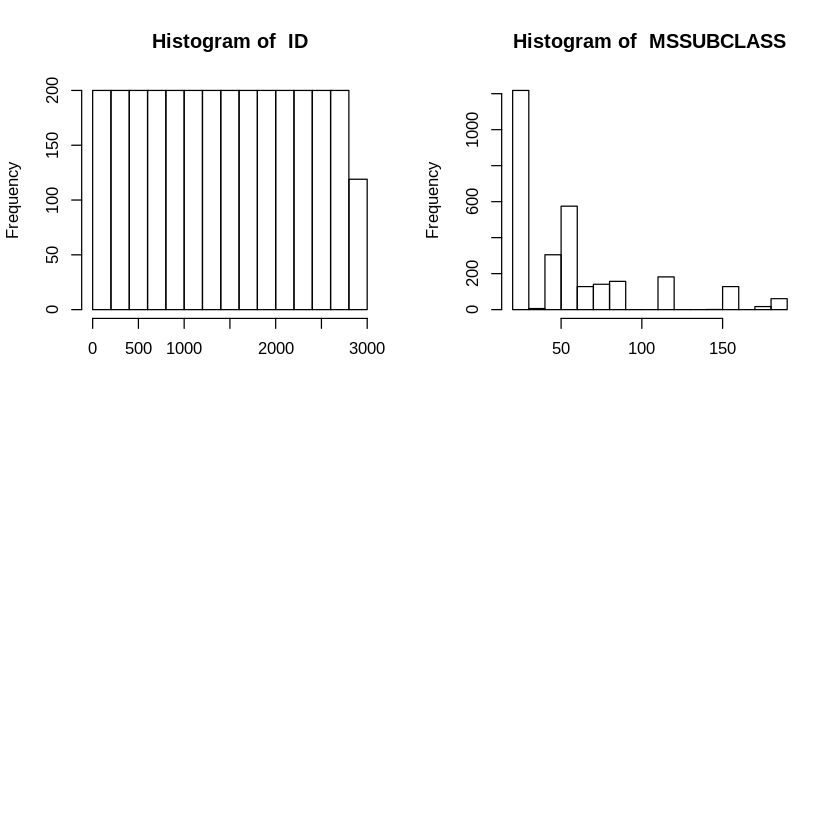

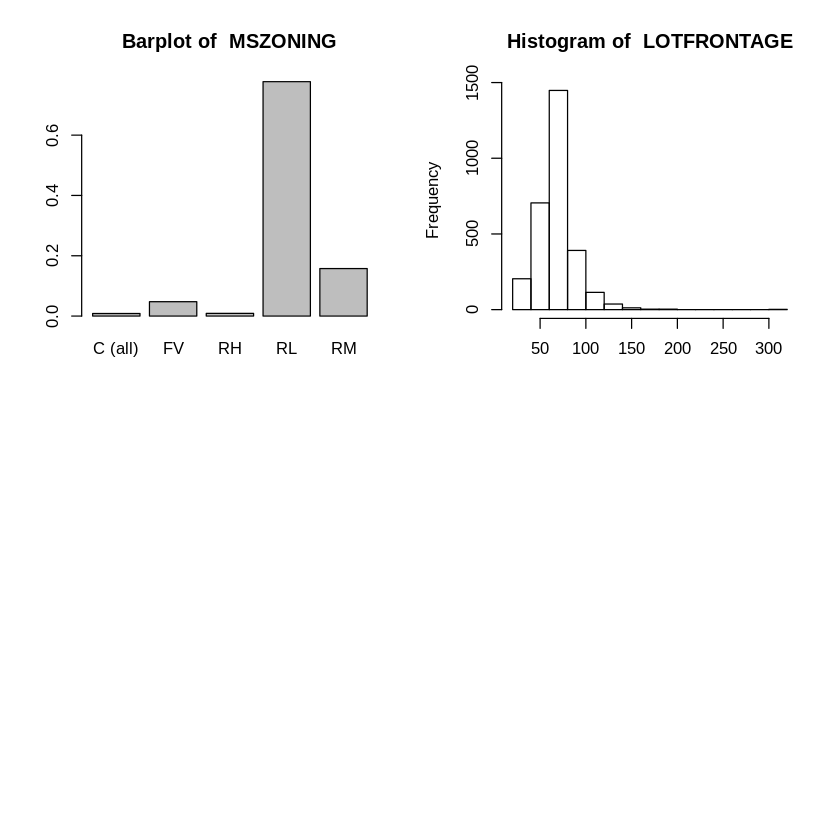

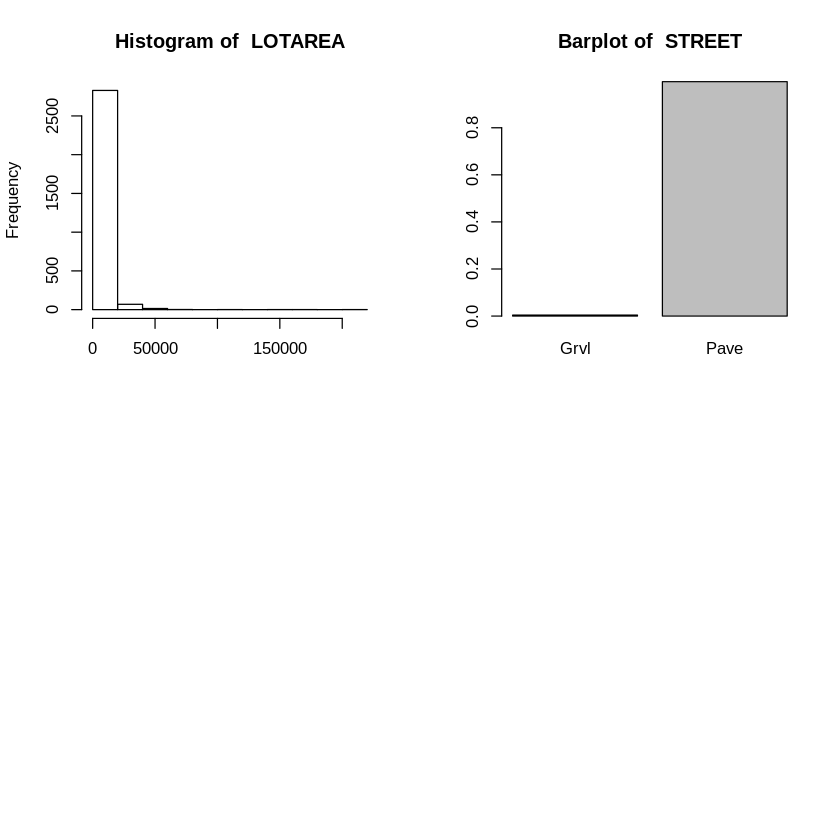

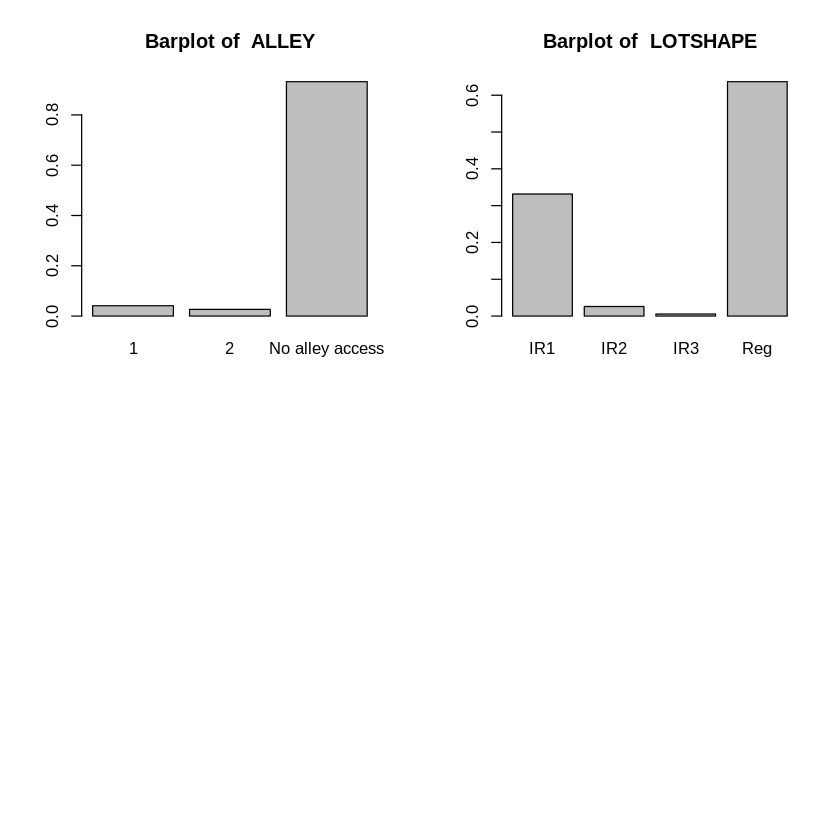

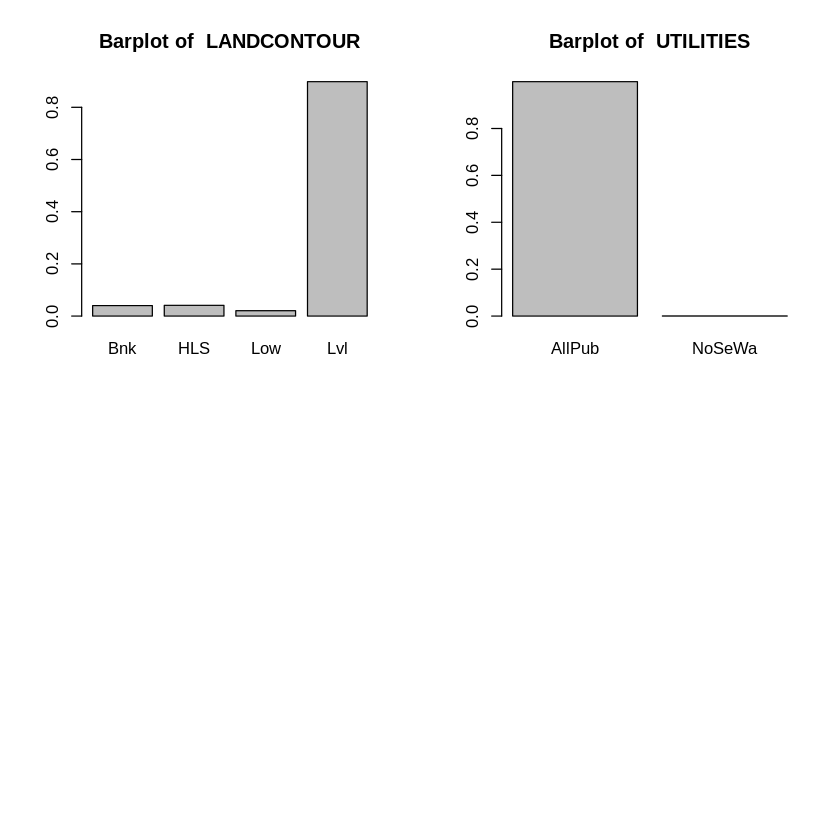

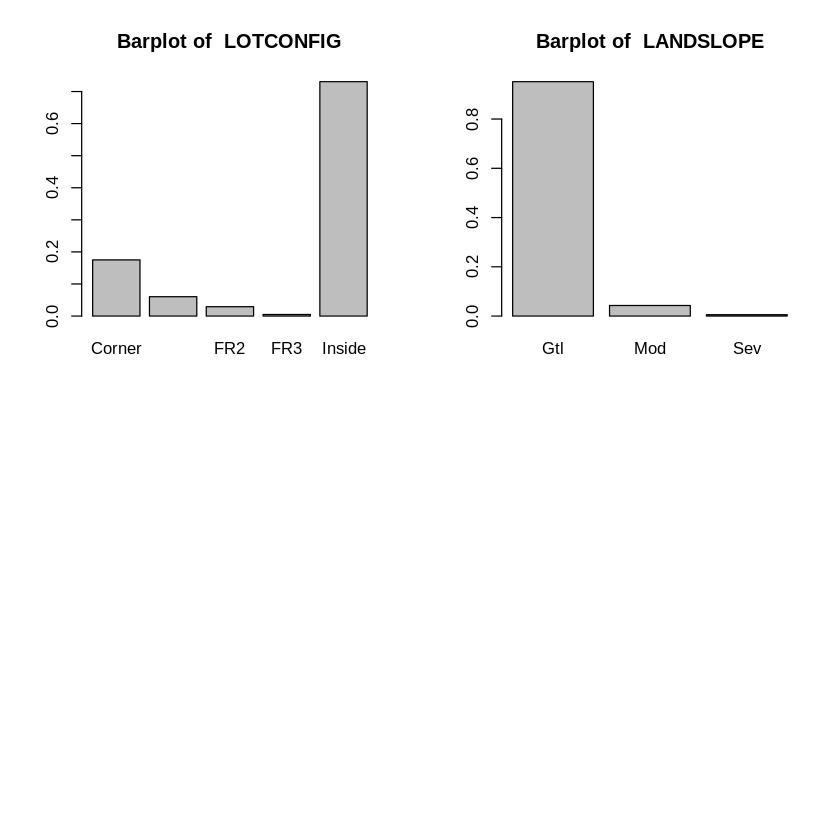

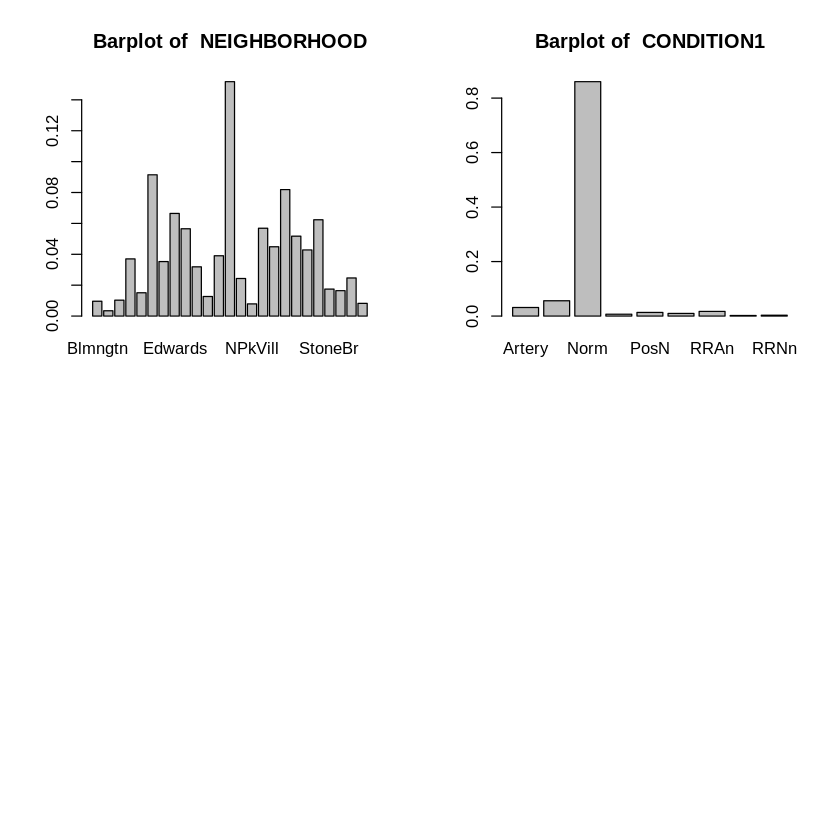

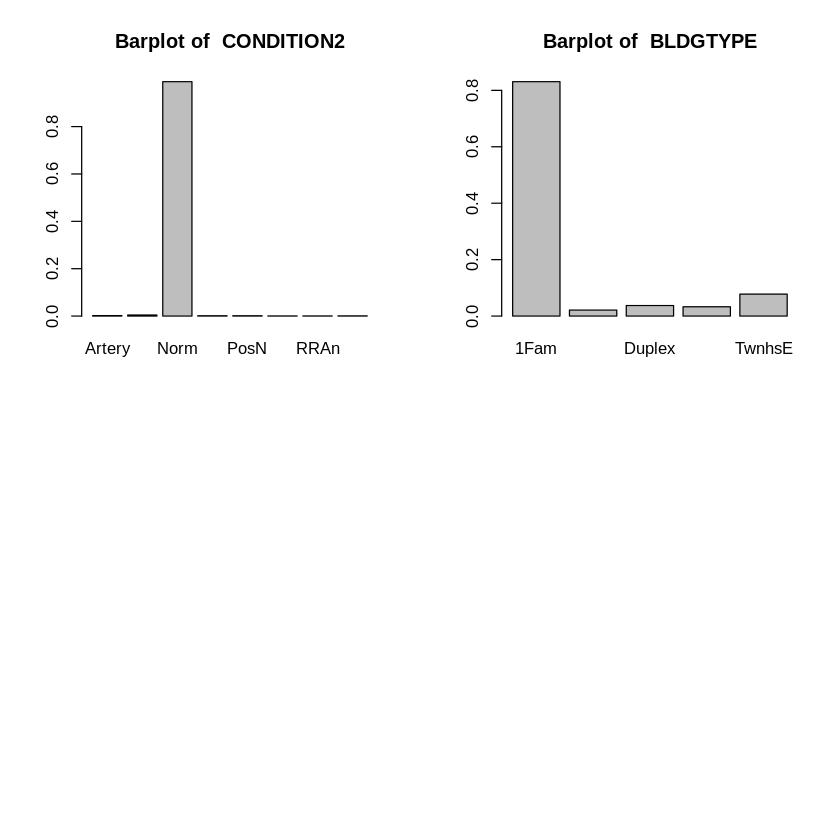

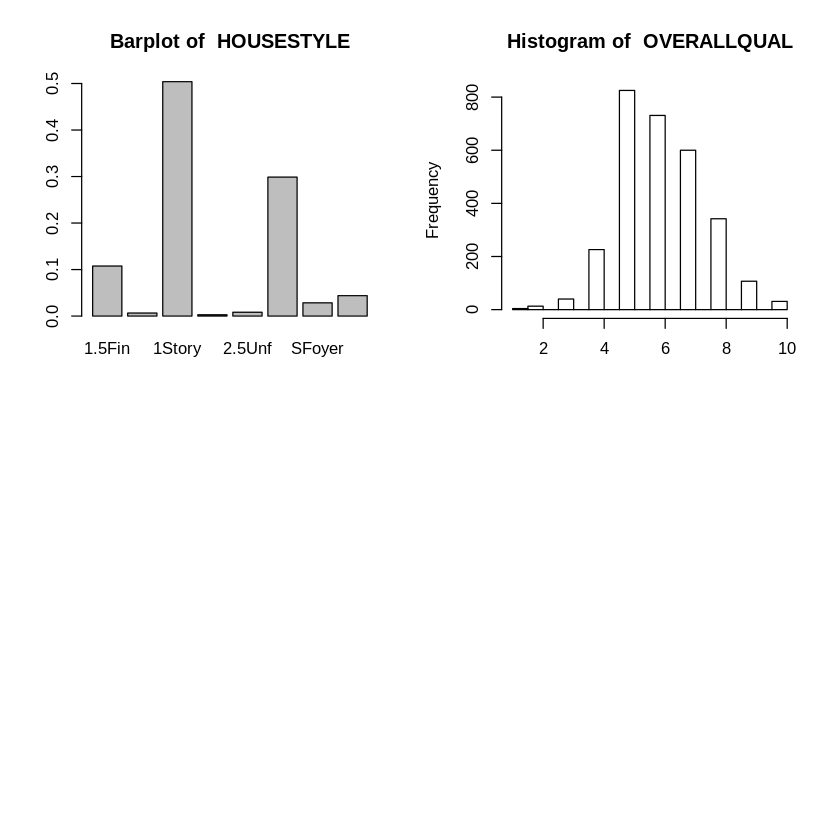

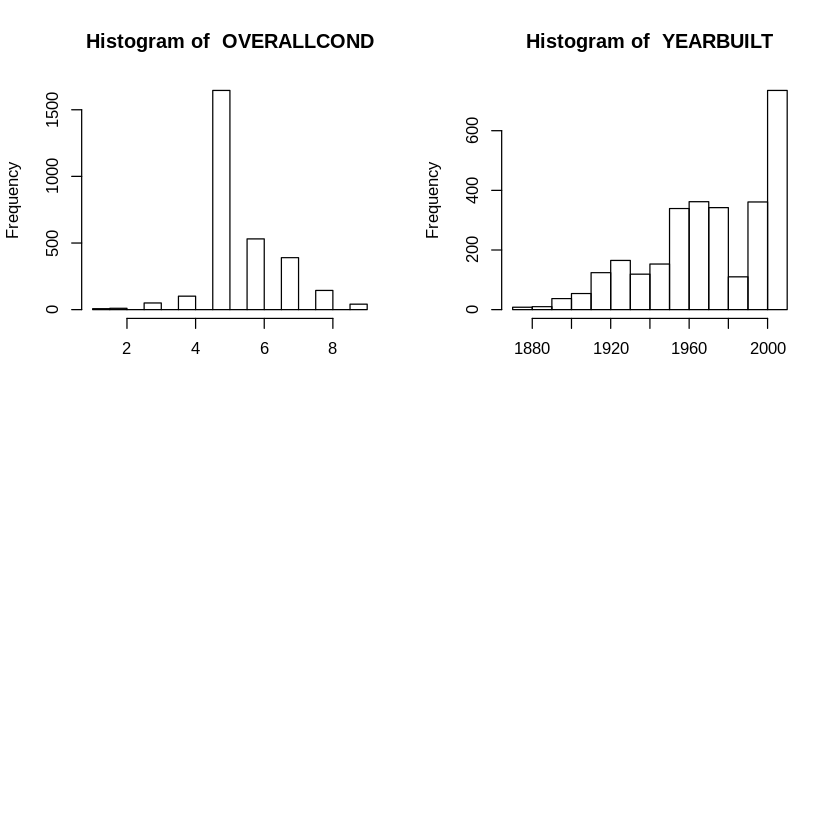

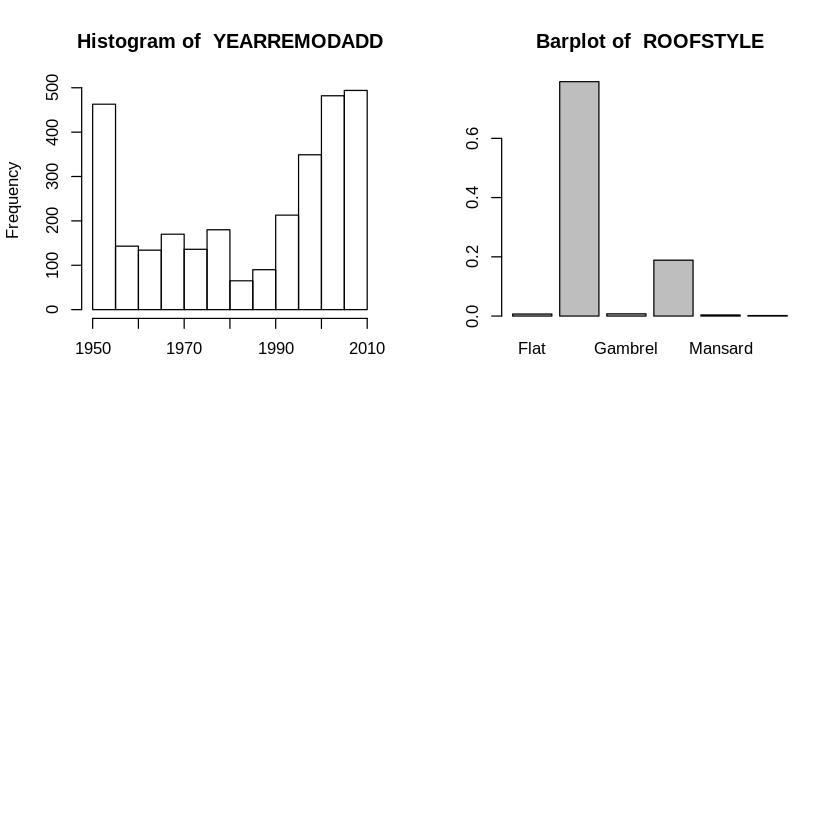

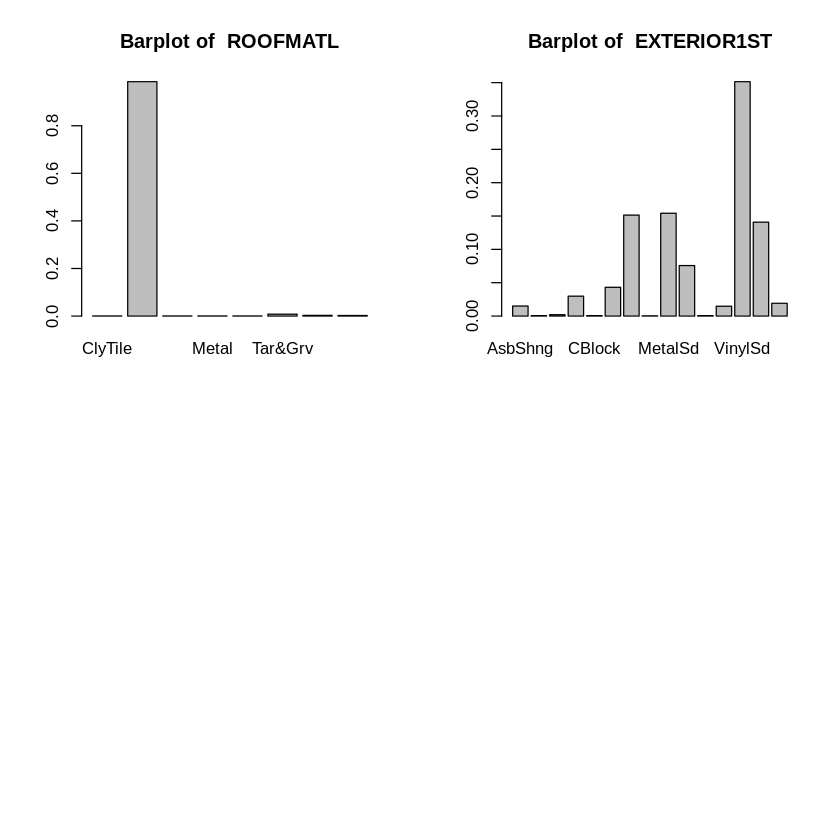

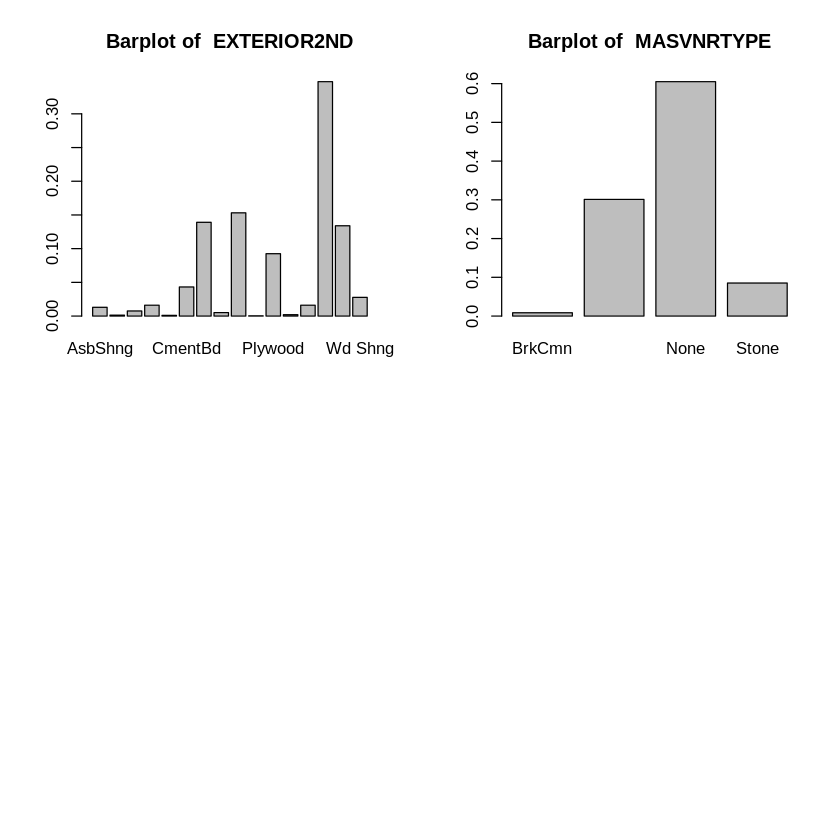

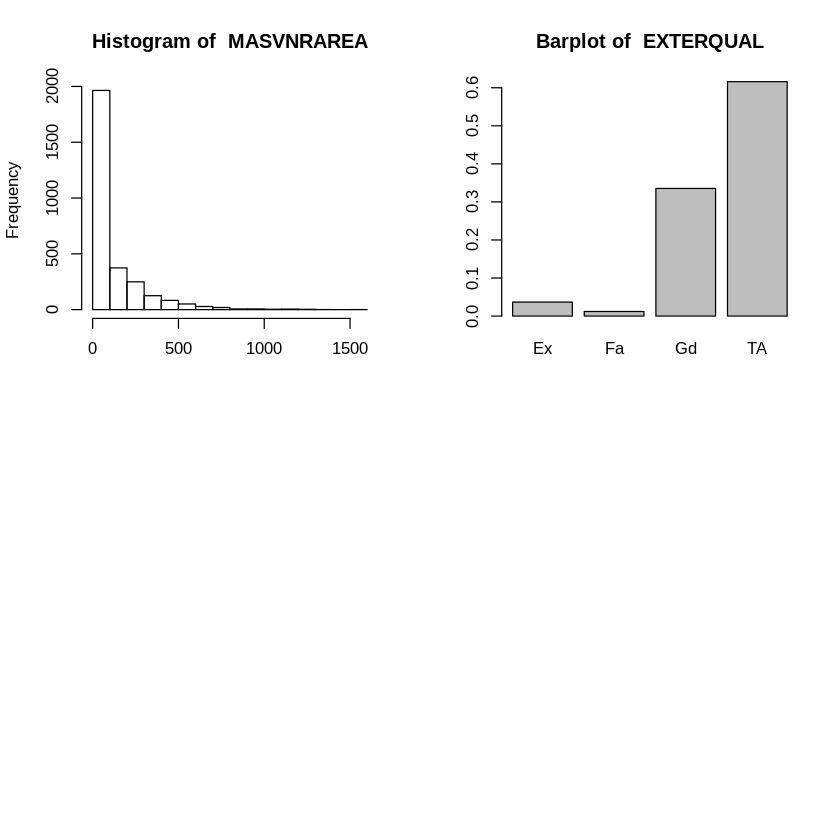

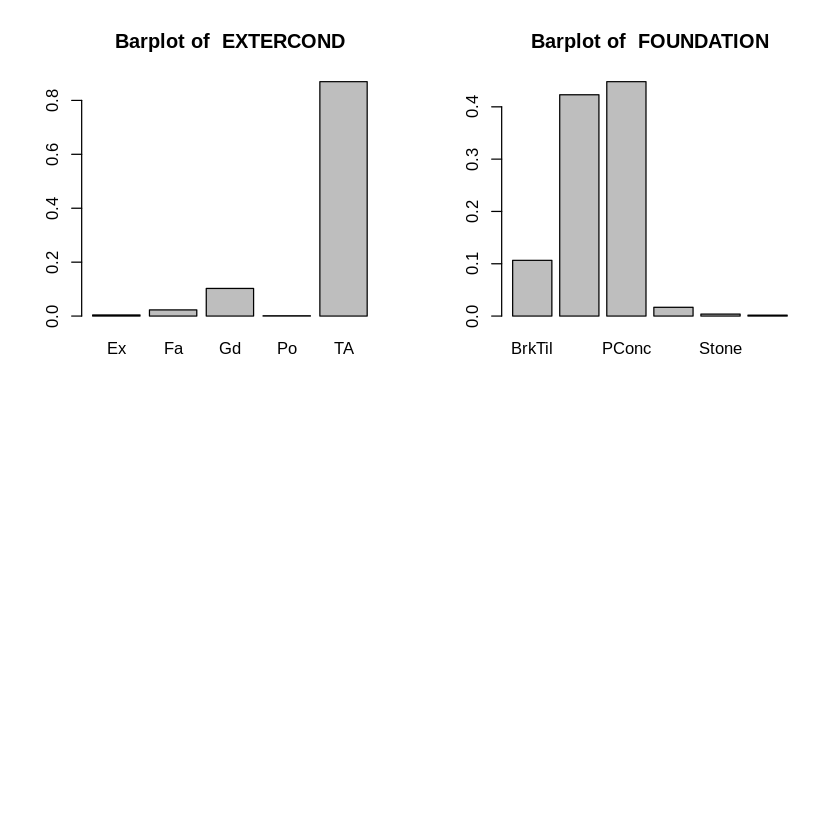

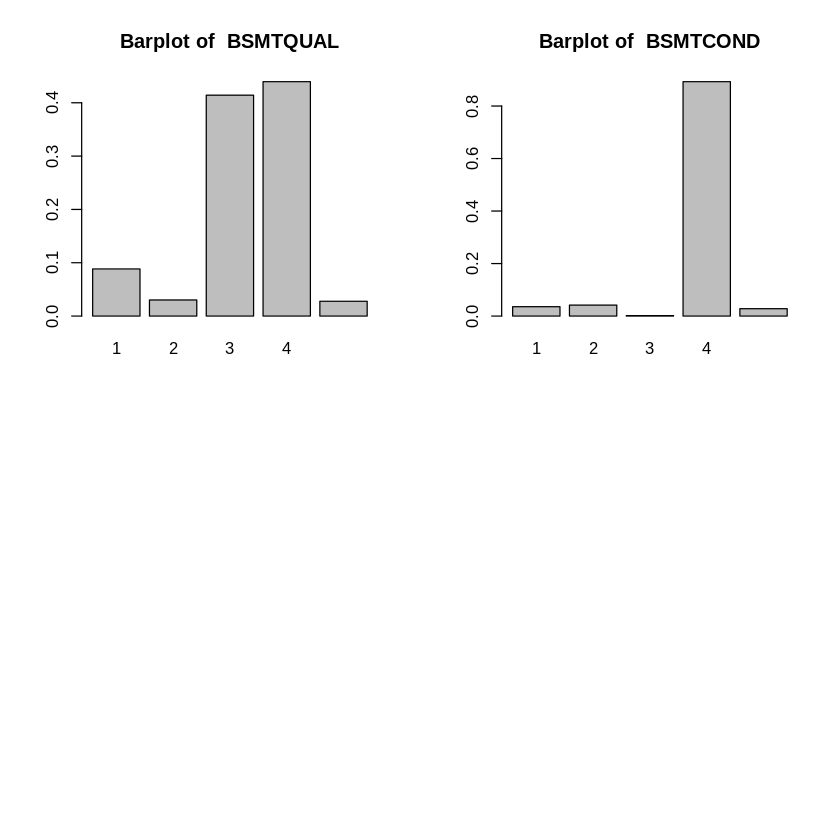

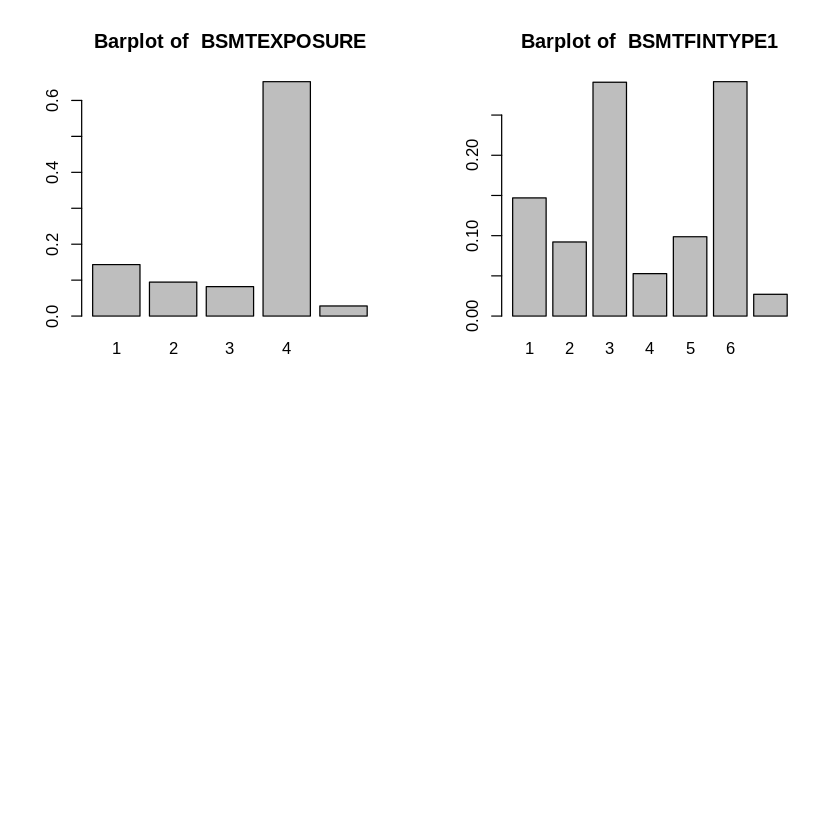

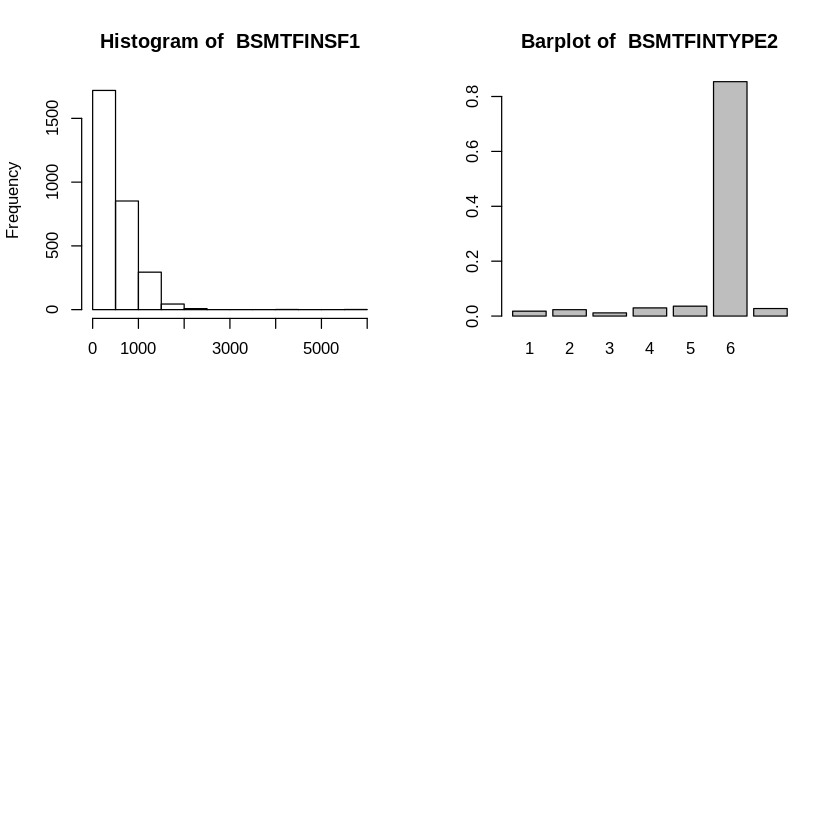

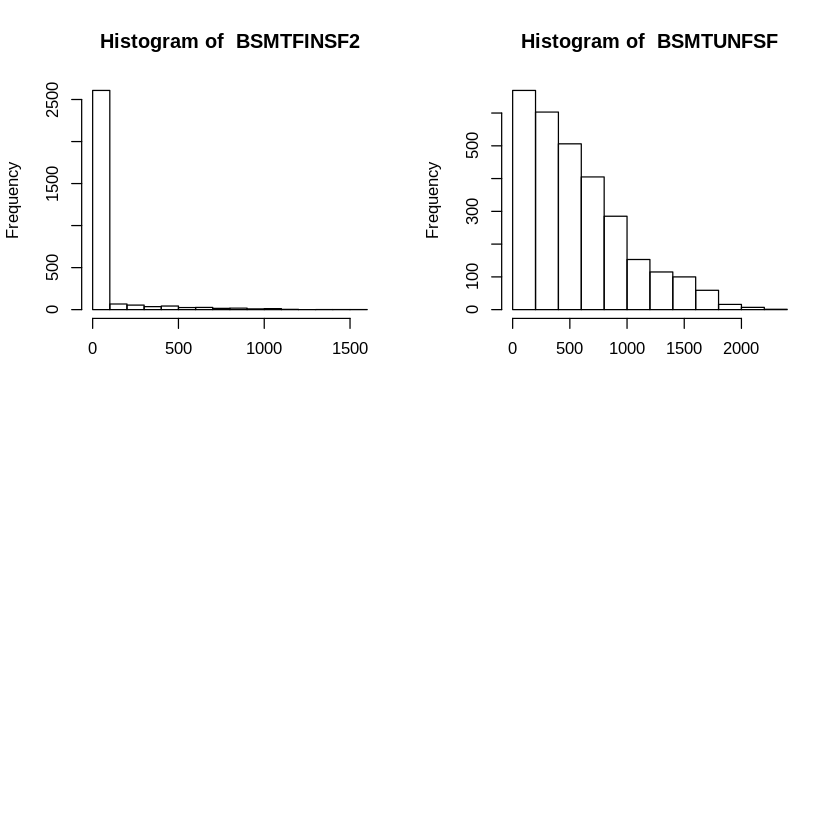

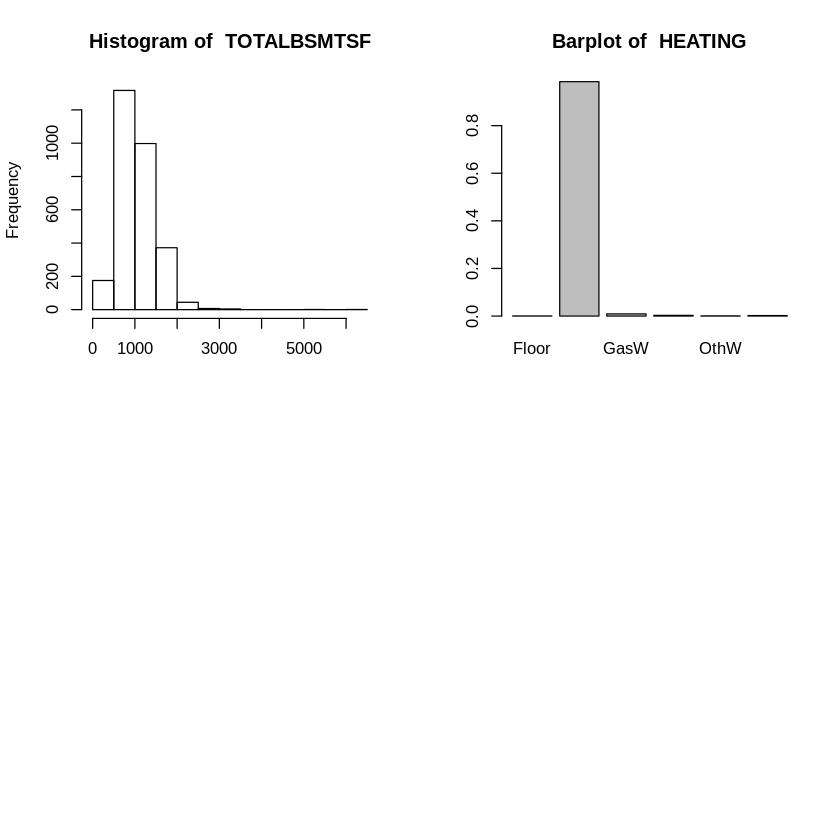

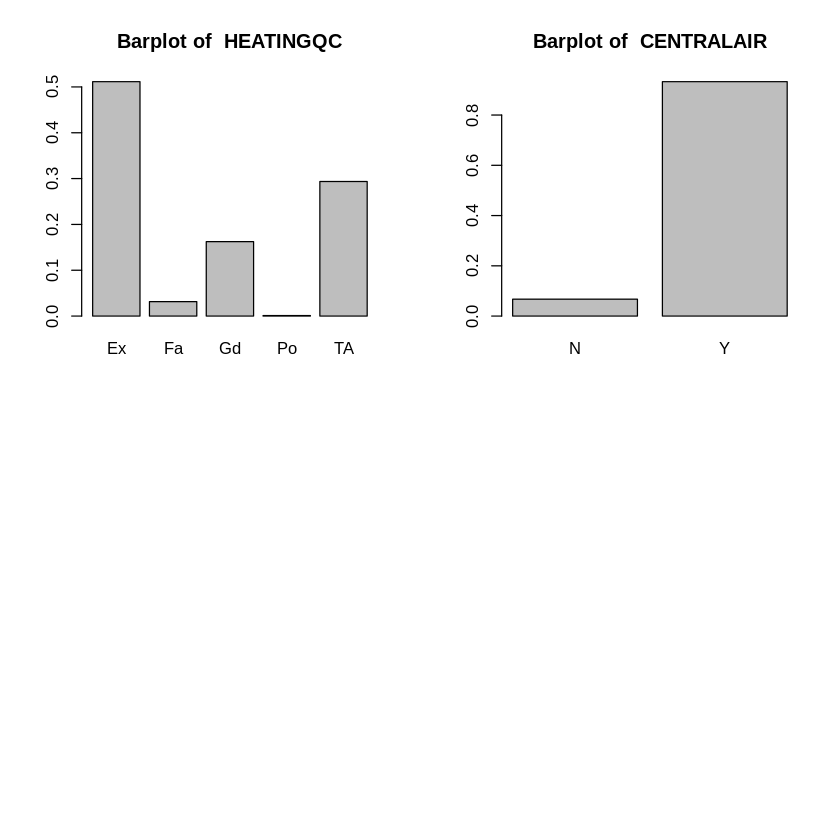

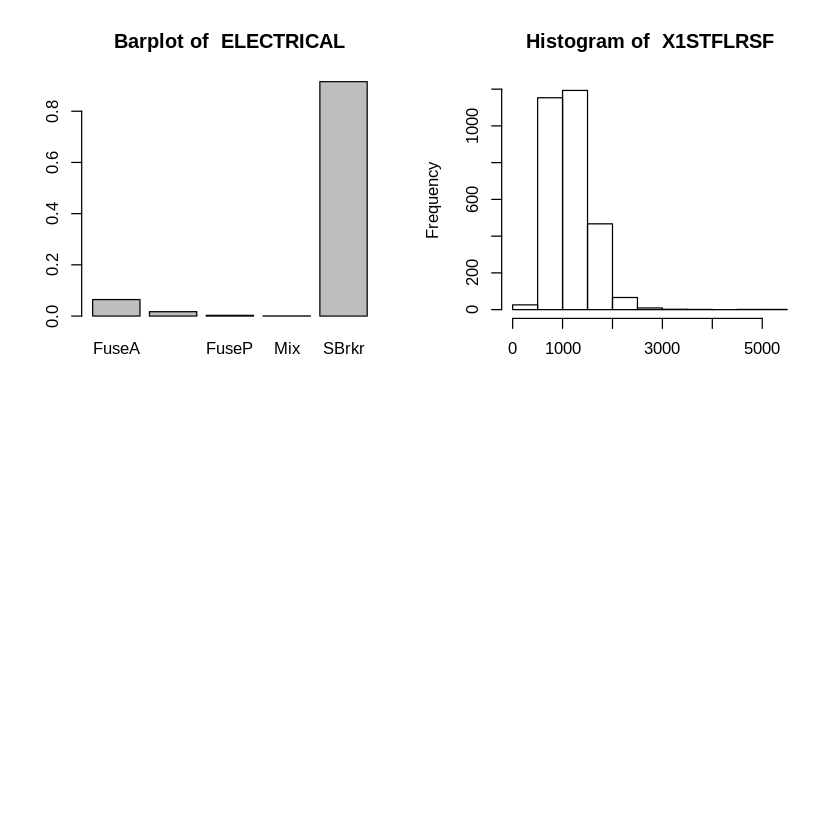

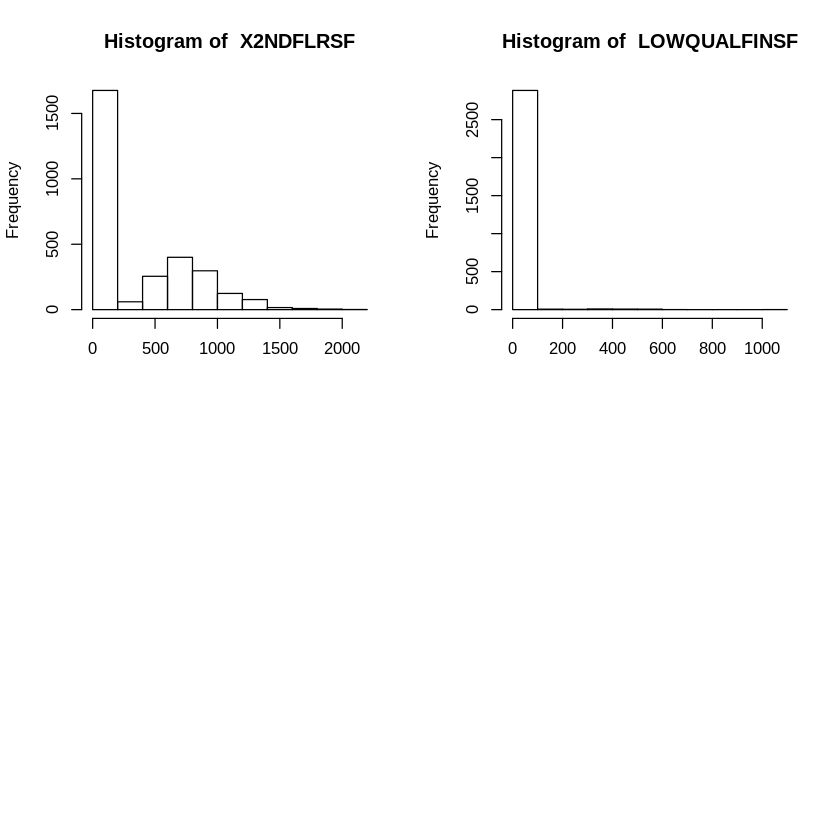

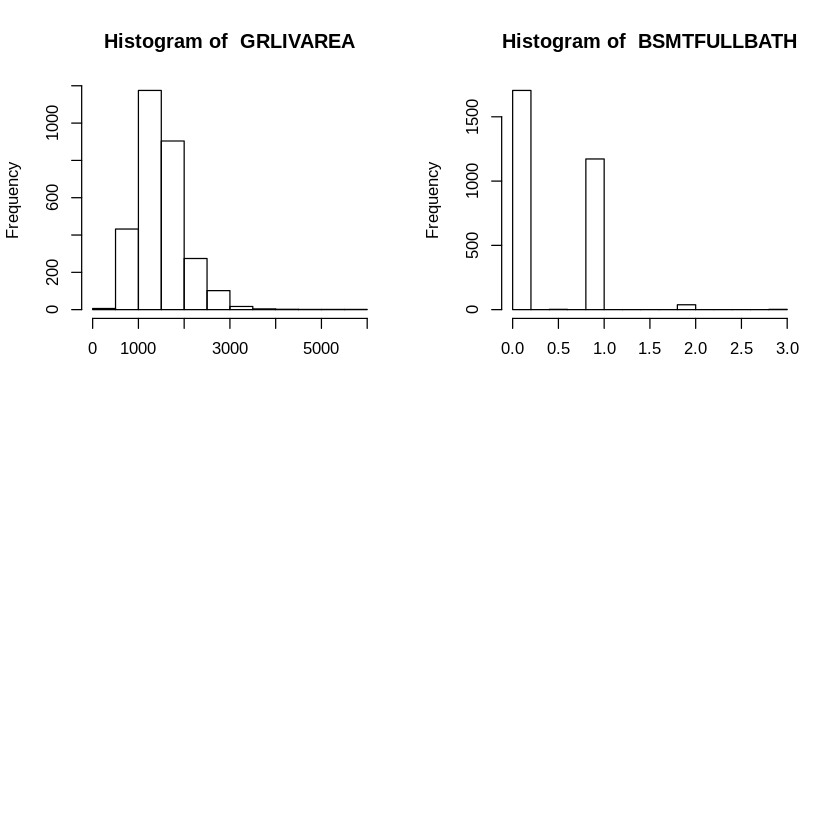

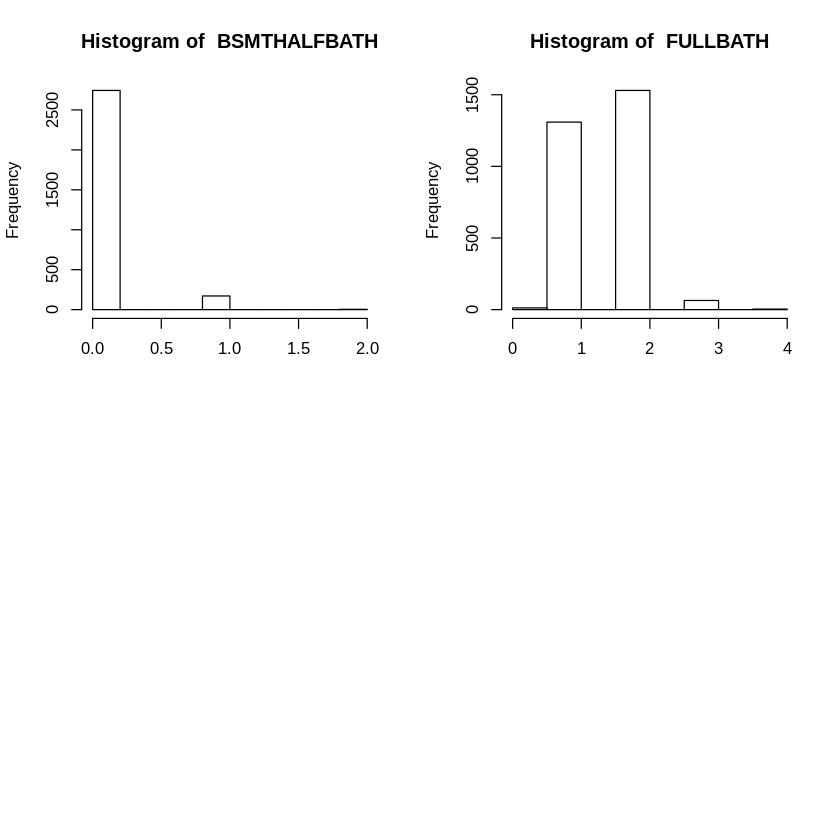

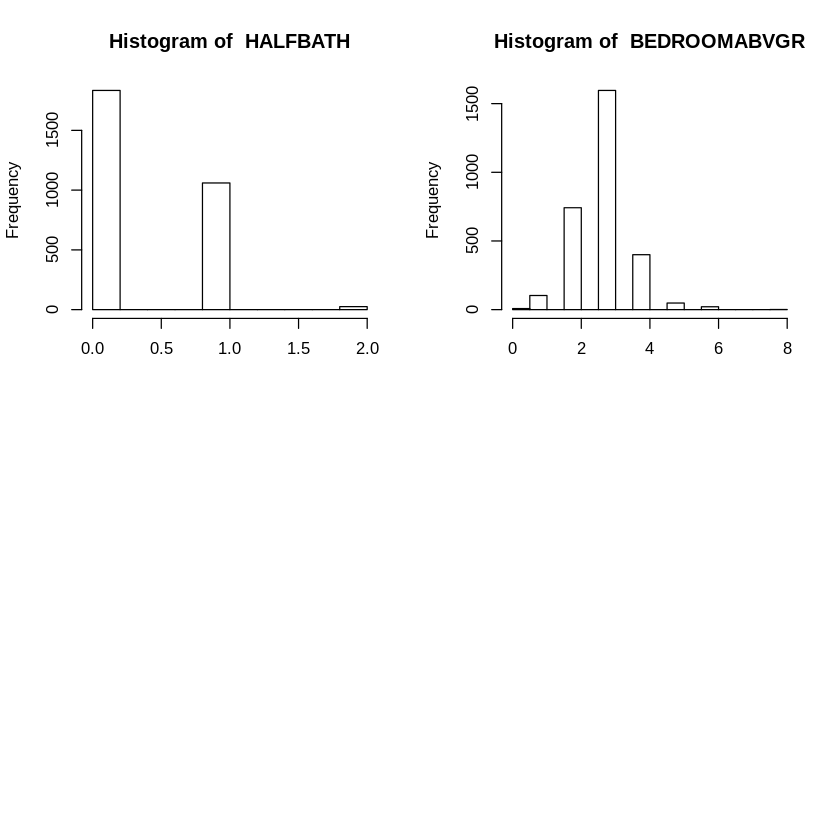

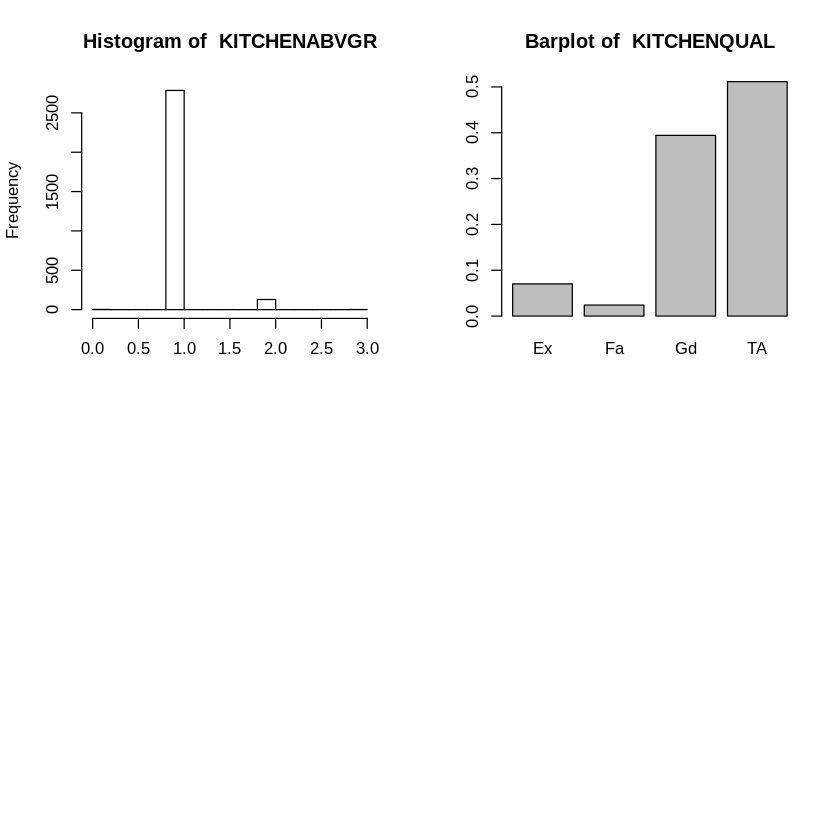

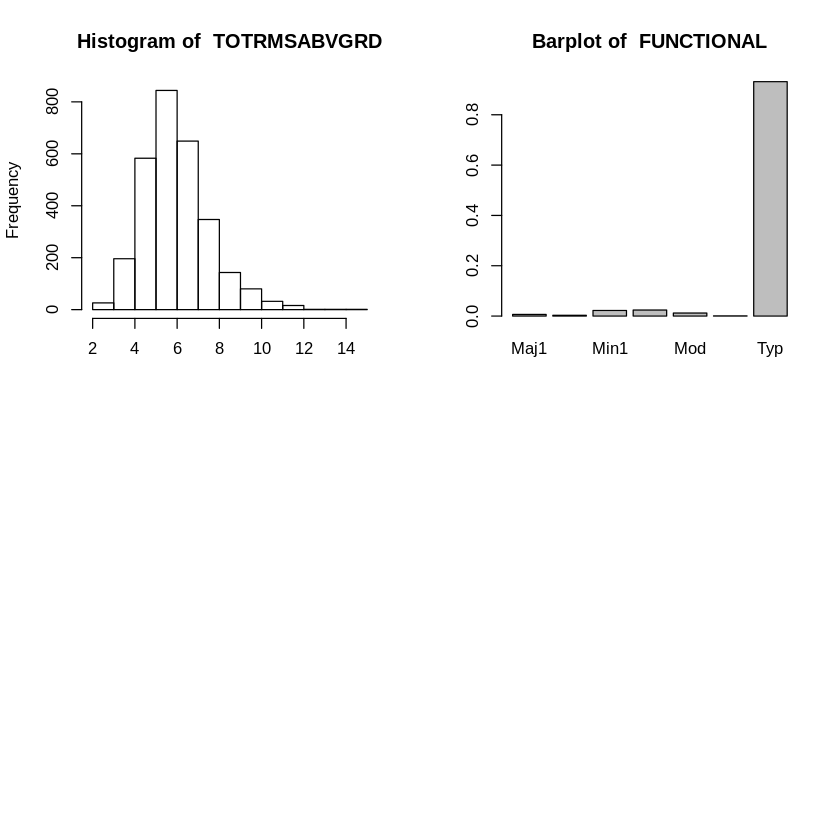

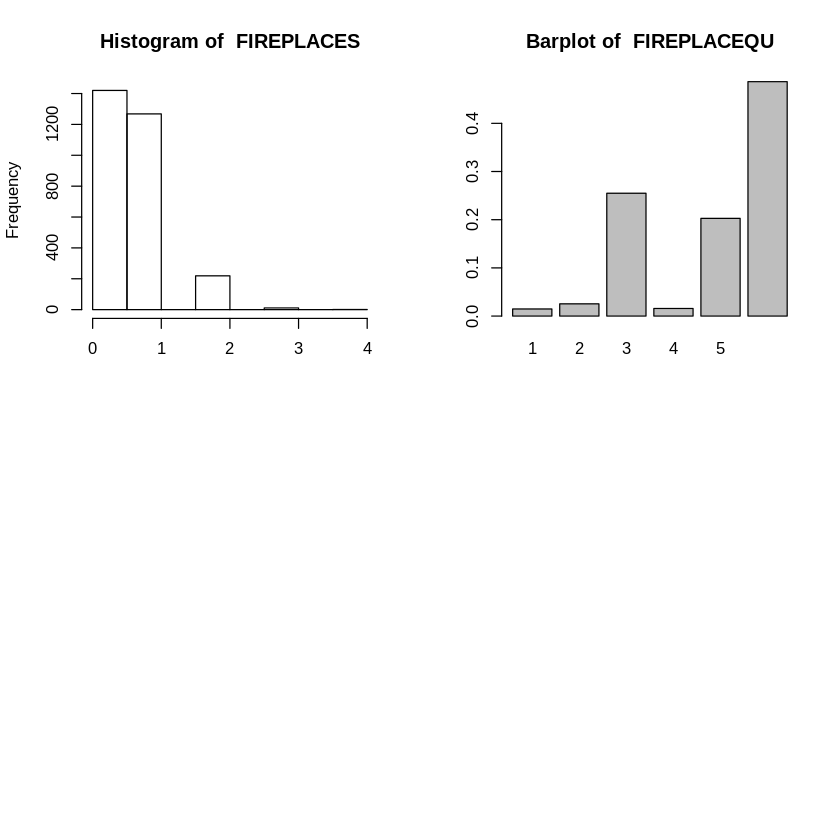

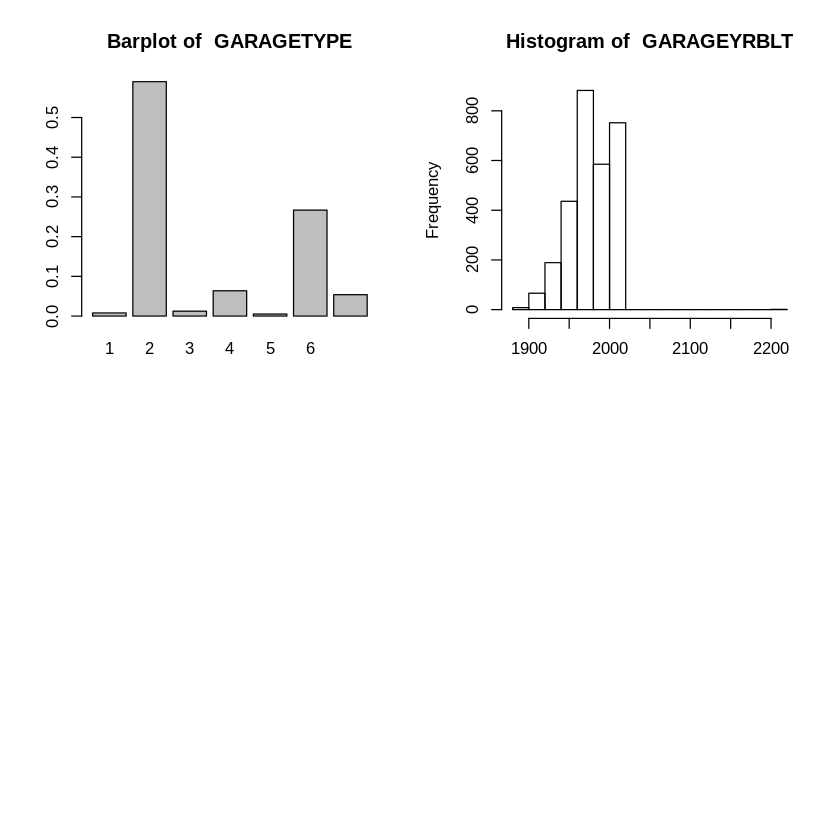

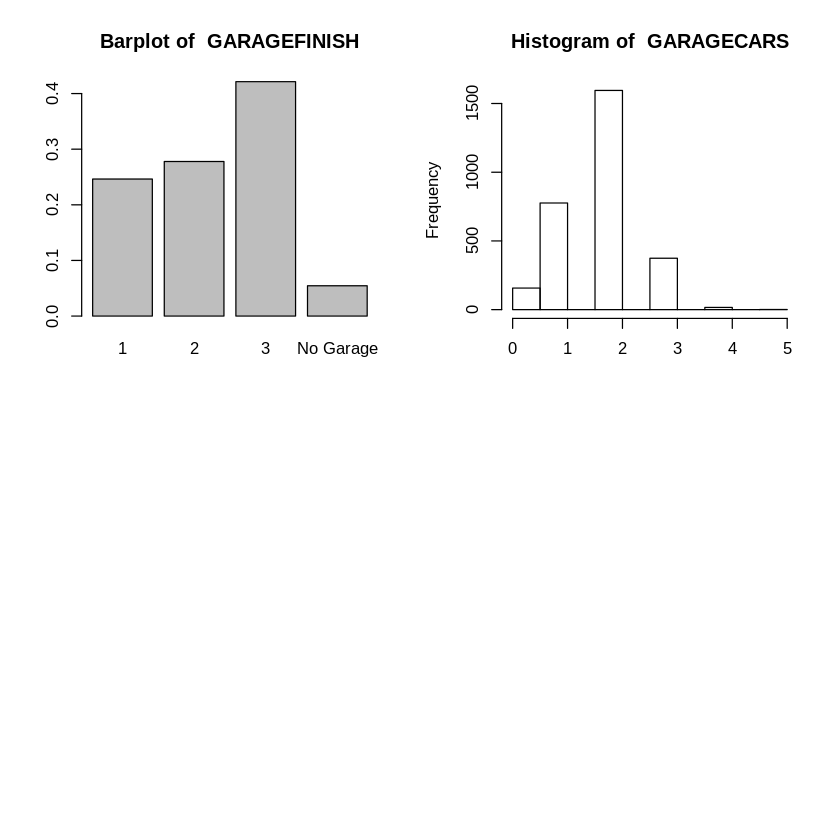

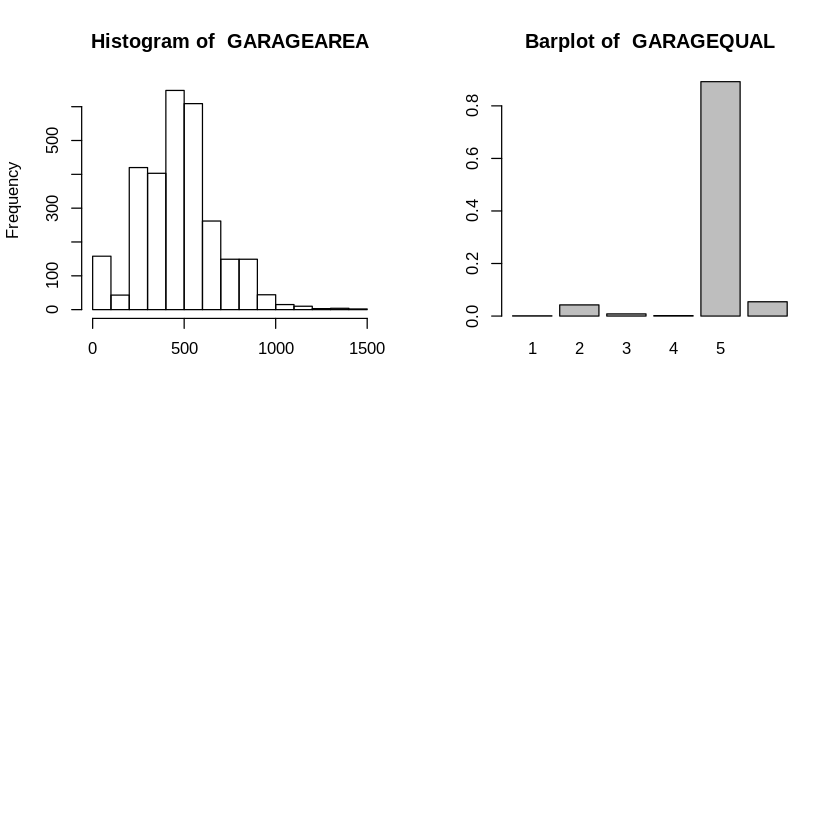

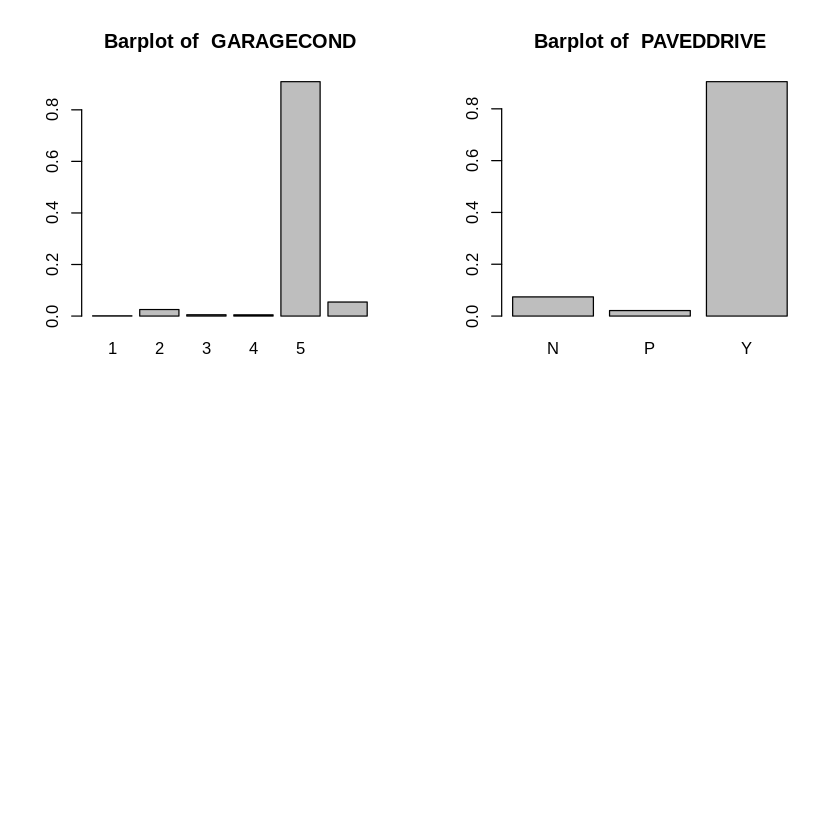

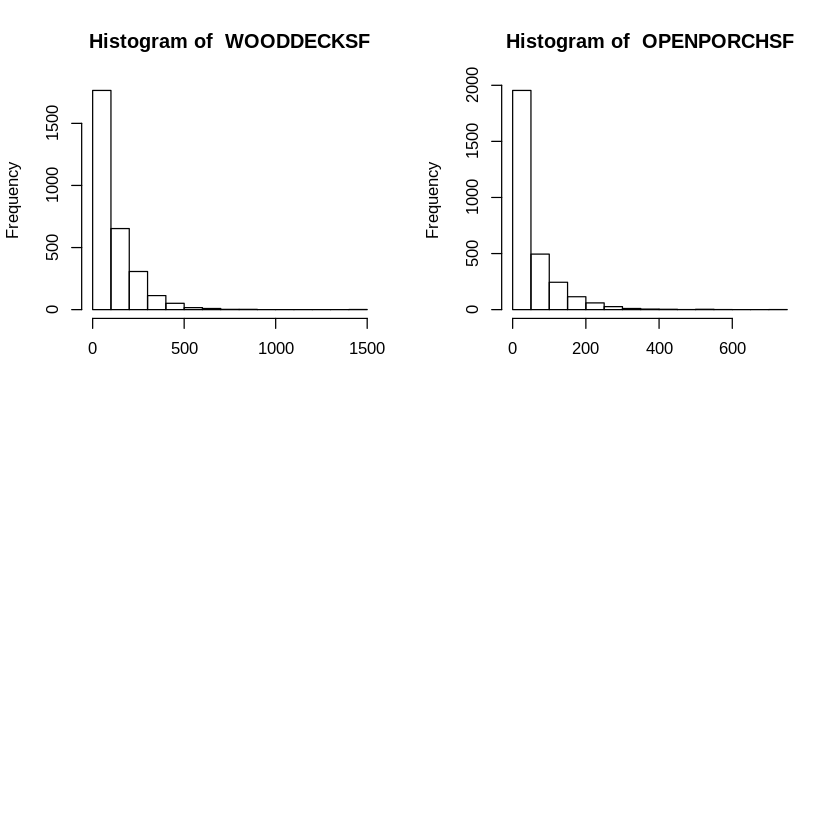

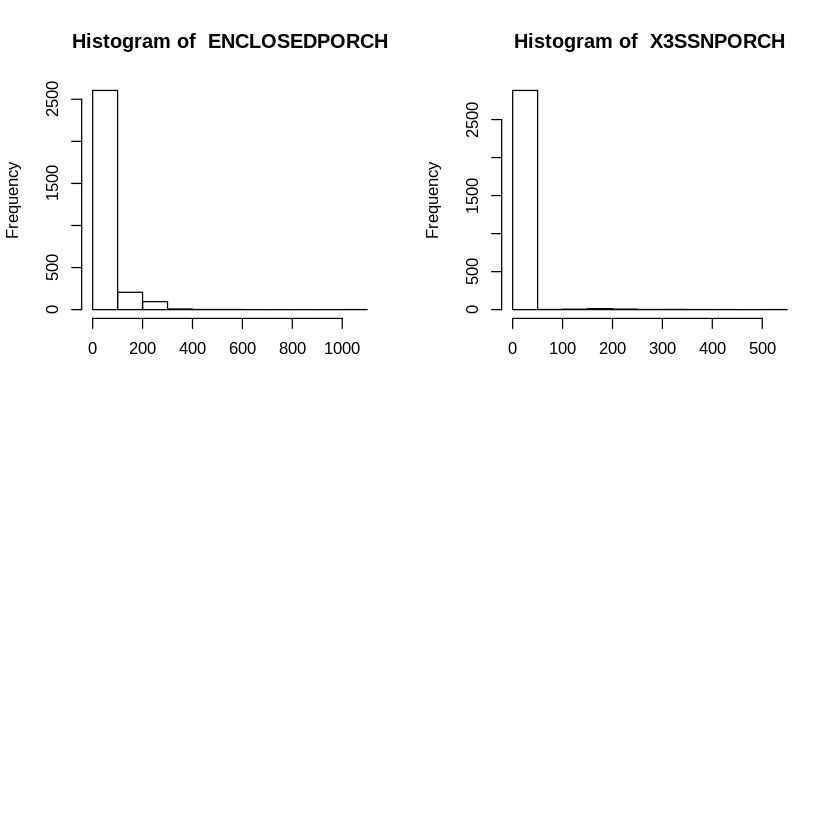

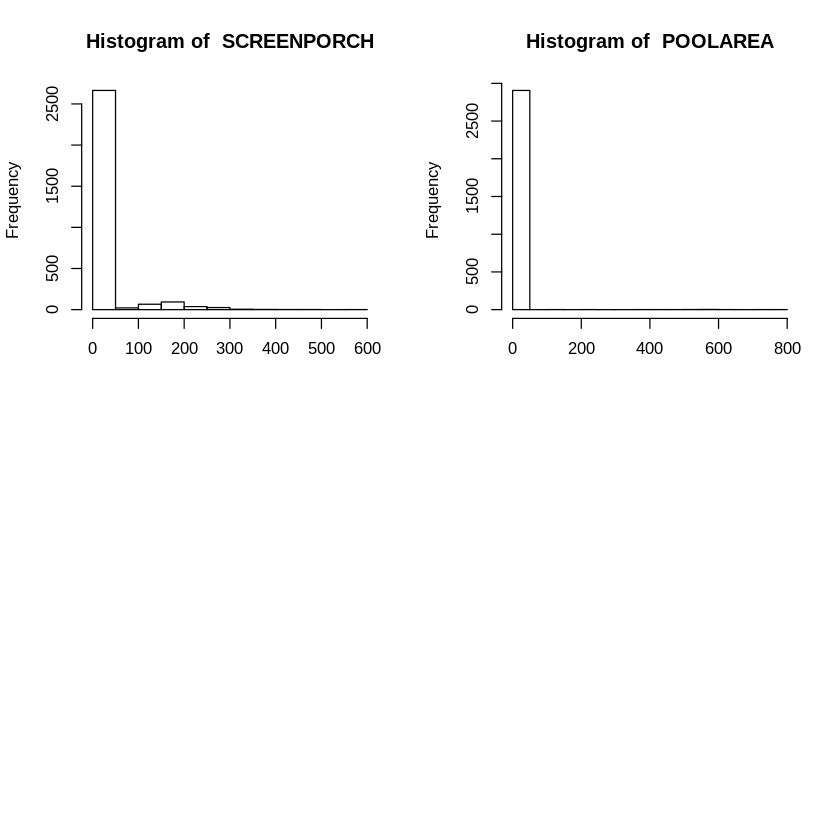

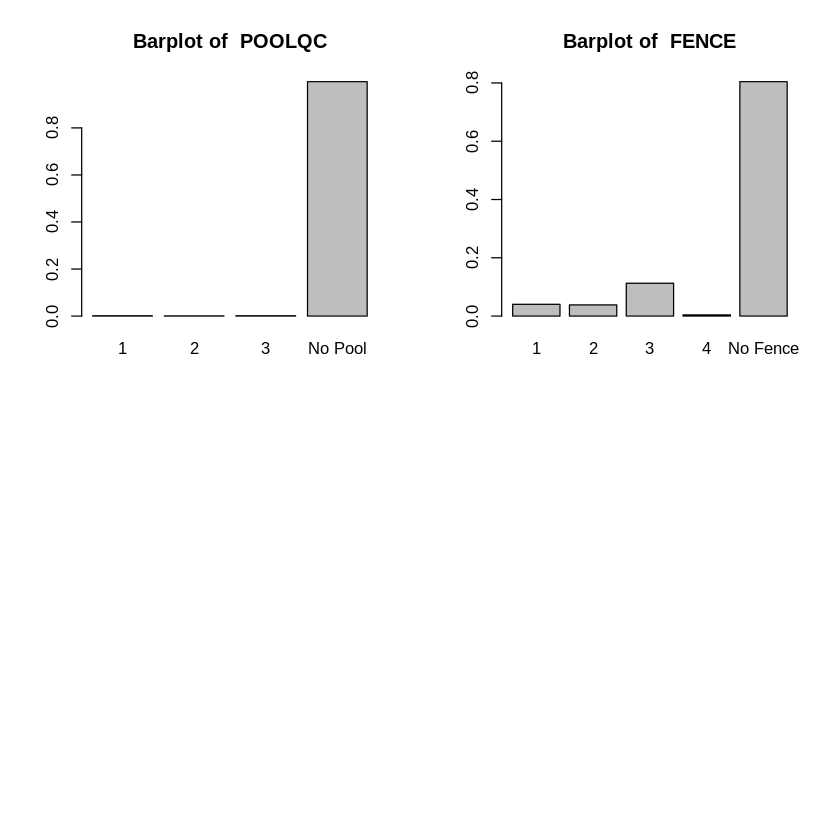

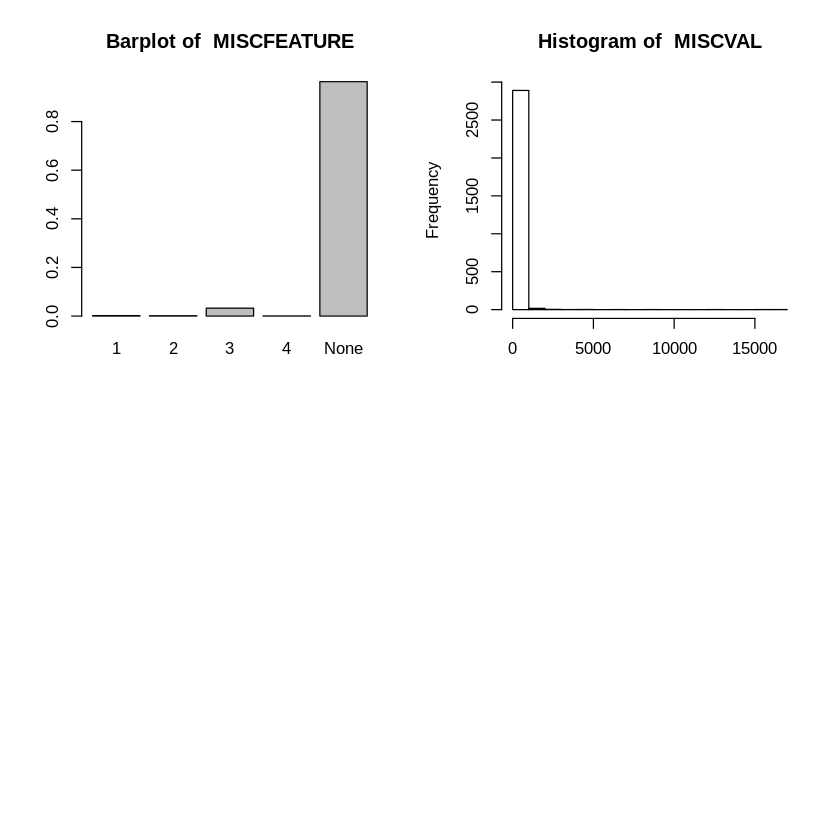

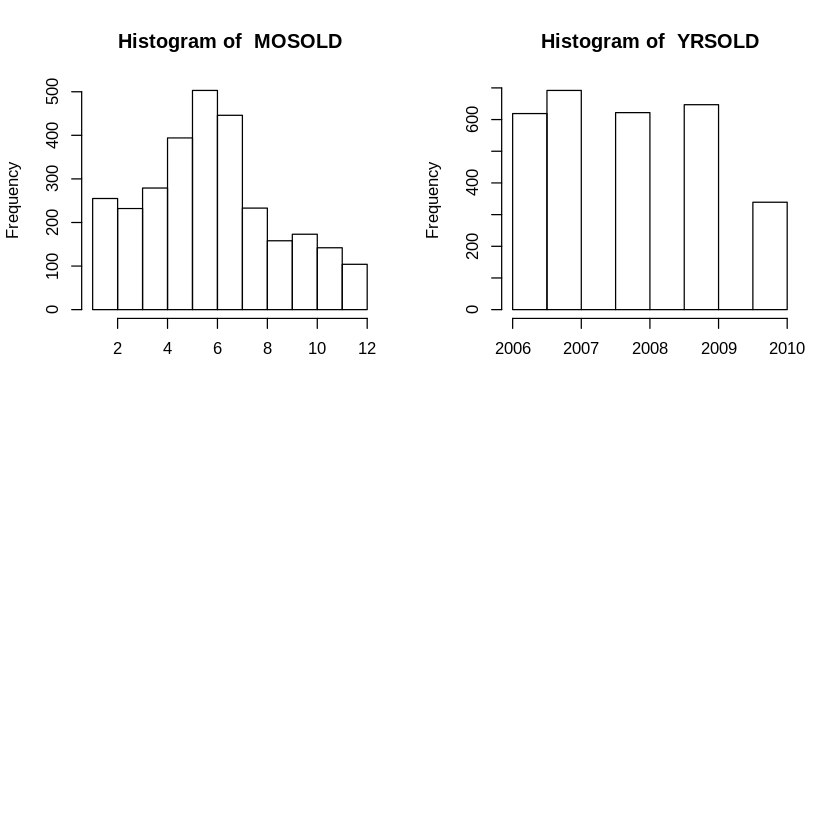

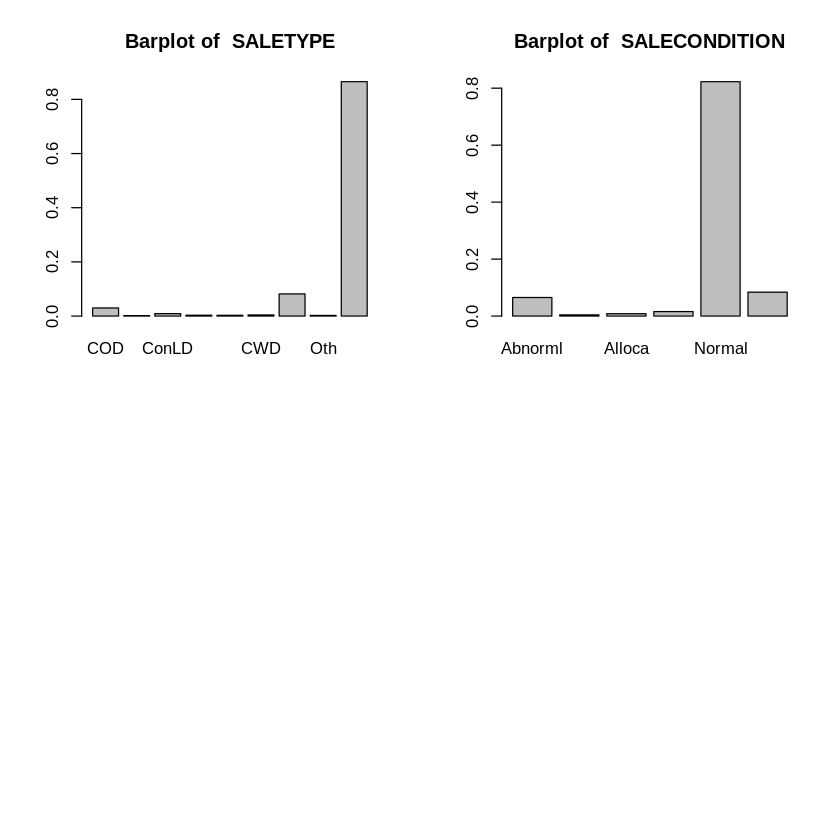

In [50]:
# Now we visulize each 
for (i in seq(1,ncol(al)-1,2)){
    par(mfrow=c(2, 2))
    desc(names(al[i]))
    desc(names(al[i+1]))
}

In [26]:
library(purrr)
library(dplyr)
library(corrplot)
library(hablar)
library(corrplot)
library(RColorBrewer)
library(MASS)
library(stats)

In [51]:
a <- data.frame(sapply(al, class))
names(a) <- c("class")
a

,class
Id,integer
MSSubClass,integer
MSZoning,factor
LotFrontage,numeric
LotArea,integer
Street,factor
Alley,character
LotShape,factor
LandContour,factor
Utilities,factor


In [4]:
a %>%
    group_by(class) %>% 
    tally()

class,n
factor,38
integer,23
numeric,12


In [47]:
train <- df[df$train_or_test == 'train',]
train <- train[ , -which(names(train) == 'train_or_test')]

test <- df[df$train_or_test == 'test',]
test <- test[ , -which(names(test) == 'train_or_test')]

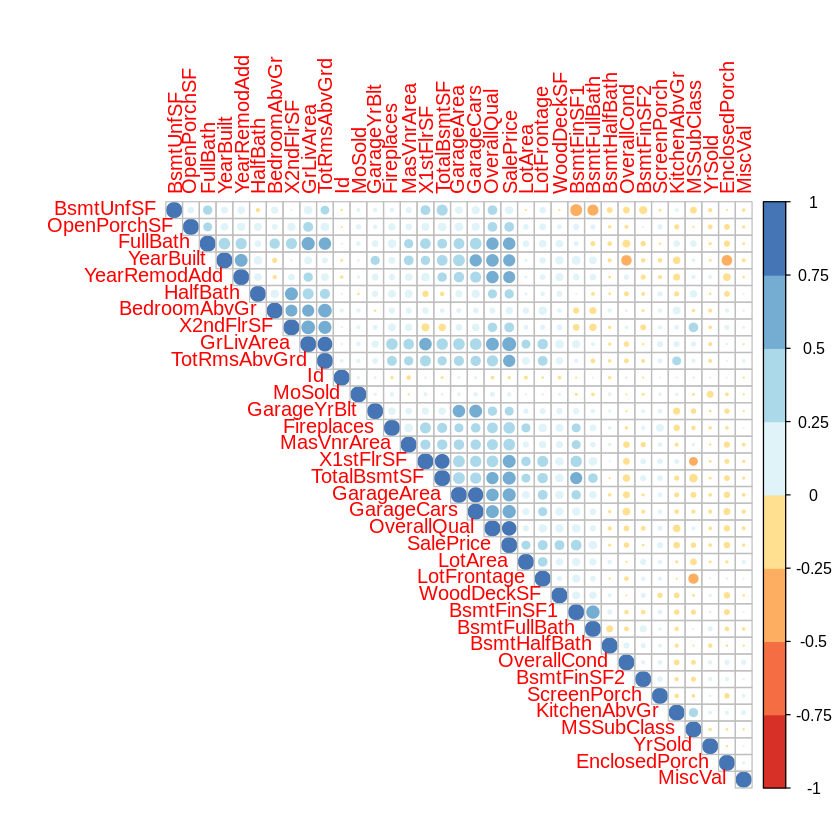

In [9]:
corrplot(cor(train %>% keep(is.numeric)), type="upper", order="hclust",
         col=brewer.pal(n=8, name="RdYlBu"))

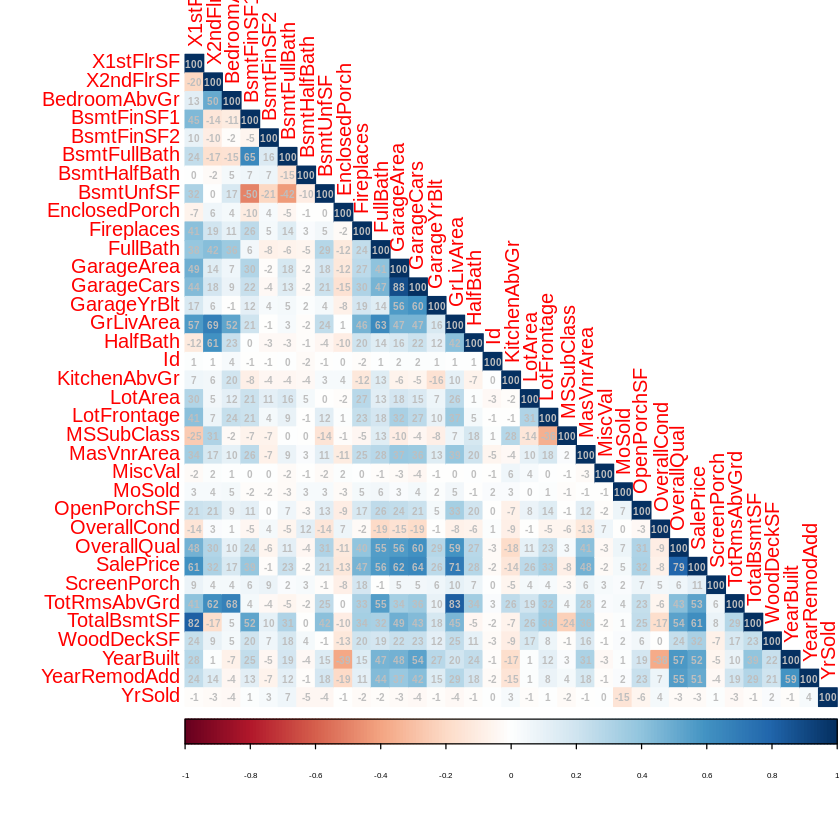

In [10]:
cex.before <- par("cex")
par(cex = 0.5)
corrplot(cor(train %>% keep(is.numeric)), insig = "blank", method = "color",
    addCoef.col="grey", type='lower',
    tl.cex = 1/par("cex"), addCoefasPercent = TRUE)
par(cex = cex.before)

In [11]:
# check if case to lower reduce number of unique values
for (i in names(train %>% keep(is.factor))){
    a = table(train[[i]])
    b = table(tolower(train[[i]]))
    if (!all(a==b)){
        print(i)
    }
    
}

In [12]:
lm1 <- lm(SalePrice ~ ., data=train)

In [14]:
names(which.min(summary(lm1)$coefficients[,4]))

[1] "OverallQual"

In [16]:
a = data.frame(summary(lm1)$coefficients)
a[order(a$Pr...t..),]

,Estimate,Std..Error,t.value,Pr...t..
OverallQual,7.699926e+03,1.205975e+03,6.384814,2.424994e-10
BsmtQualGd,-2.527810e+04,4.017539e+03,-6.291937,4.346979e-10
KitchenQualGd,-2.555261e+04,4.193988e+03,-6.092677,1.481817e-09
KitchenQualTA,-2.513492e+04,4.718060e+03,-5.327384,1.183462e-07
NeighborhoodStoneBr,5.098325e+04,9.977923e+03,5.109605,3.738073e-07
GarageCars,1.346132e+04,2.678225e+03,5.026209,5.740972e-07
LotArea,5.978521e-01,1.235432e-01,4.839214,1.468357e-06
GarageQualFa,-1.603765e+05,3.353469e+04,-4.782406,1.940877e-06
NeighborhoodNoRidge,4.770194e+04,1.010855e+04,4.718971,2.641149e-06
BsmtQualTA,-2.335829e+04,4.982119e+03,-4.688425,3.059516e-06


In [21]:
# Automated variable selection
fit <- lm(formula = SalePrice ~ ., data = train) 
automate_variable_selection <- stepAIC(fit, direction="both")

Start:  AIC=30048.03
SalePrice ~ X1stFlrSF + X2ndFlrSF + Alley + BedroomAbvGr + BldgType + 
    BsmtCond + BsmtExposure + BsmtFinSF1 + BsmtFinSF2 + BsmtFinType1 + 
    BsmtFinType2 + BsmtFullBath + BsmtHalfBath + BsmtQual + BsmtUnfSF + 
    CentralAir + Condition1 + Electrical + EnclosedPorch + ExterCond + 
    ExterQual + Exterior1st + Exterior2nd + Fence + FireplaceQu + 
    Fireplaces + Foundation + FullBath + Functional + GarageArea + 
    GarageCars + GarageCond + GarageFinish + GarageQual + GarageType + 
    GarageYrBlt + GrLivArea + HalfBath + HeatingQC + HouseStyle + 
    Id + KitchenAbvGr + KitchenQual + LandContour + LandSlope + 
    LotArea + LotConfig + LotFrontage + LotShape + MSSubClass + 
    MSZoning + MasVnrArea + MasVnrType + MiscFeature + MiscVal + 
    MoSold + Neighborhood + OpenPorchSF + OverallCond + OverallQual + 
    PavedDrive + RoofStyle + SaleCondition + SaleType + ScreenPorch + 
    TotRmsAbvGrd + TotalBsmtSF + WoodDeckSF + YearBuilt + YearRemodAdd + 
    Y

In [22]:
only_significat_vars <- names(automate_variable_selection$contrasts)

In [23]:
final_df <- train[only_significat_vars]
dim(final_df)

[1] 1460   19

In [25]:
lm3 <- lm(SalePrice ~ ., data= cbind(train[only_significat_vars], train["SalePrice"]))
summary(lm3)


Call:
lm(formula = SalePrice ~ ., data = cbind(train[only_significat_vars], 
    train["SalePrice"]))

Residuals:
    Min      1Q  Median      3Q     Max 
-200936  -18647   -1121   15495  328170 

Coefficients: (2 not defined because of singularities)
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              3.119e+05  3.796e+04   8.216 4.90e-16 ***
BldgType2fmCon          -7.272e+03  7.339e+03  -0.991 0.321930    
BldgTypeDuplex           1.546e+02  5.967e+03   0.026 0.979339    
BldgTypeTwnhs           -5.703e+04  7.860e+03  -7.256 6.71e-13 ***
BldgTypeTwnhsE          -5.323e+04  5.179e+03 -10.278  < 2e-16 ***
BsmtExposureGd           3.292e+04  4.405e+03   7.474 1.40e-13 ***
BsmtExposureMn           1.398e+03  4.637e+03   0.301 0.763087    
BsmtExposureNo          -9.275e+03  3.311e+03  -2.802 0.005159 ** 
BsmtExposureNo Basement -1.569e+04  3.656e+04  -0.429 0.667800    
BsmtFinType1BLQ         -4.459e+02  4.060e+03  -0.110 0.912555    
BsmtFinTyp

In [128]:
write.csv(cbind('Id'=test$Id, 'SalePrice'=pred), "submission.csv", row.names=FALSE)